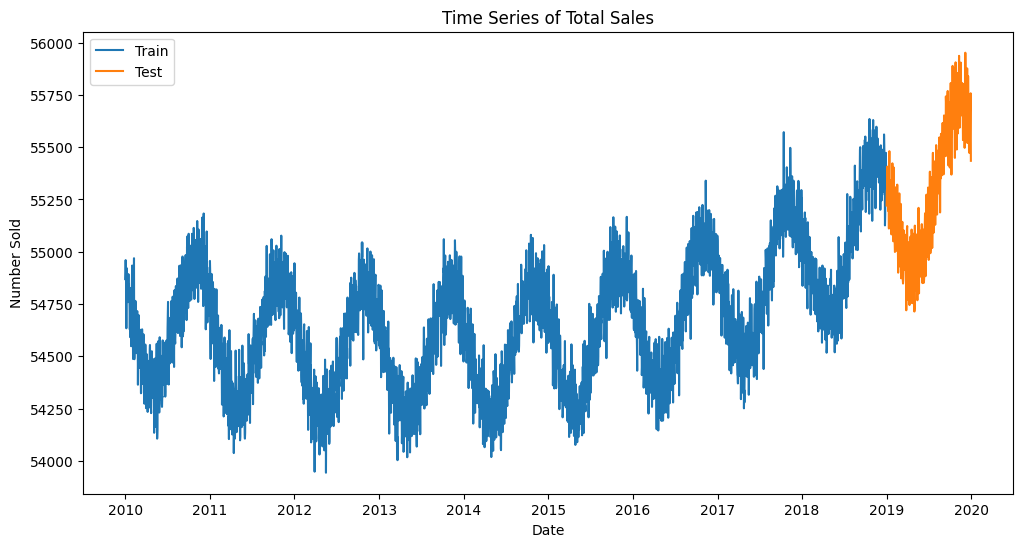

Results of Dickey-Fuller Test:
Test Statistic                   -2.532370
p-value                           0.107796
#Lag Used                        29.000000
Number of Observations Used    3257.000000
Critical Value (1%)              -3.432359
Critical Value (5%)              -2.862428
Critical Value (10%)             -2.567243
dtype: float64
Order of differencing: 1


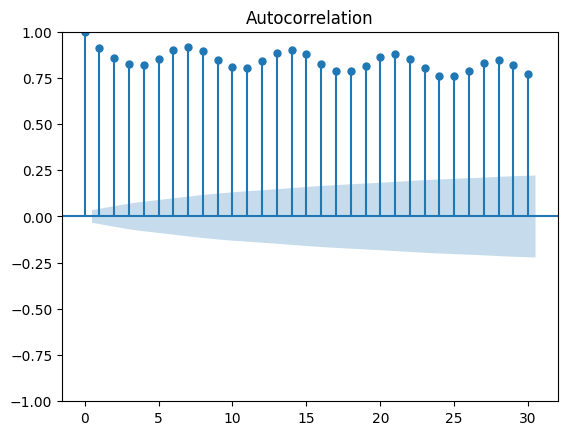

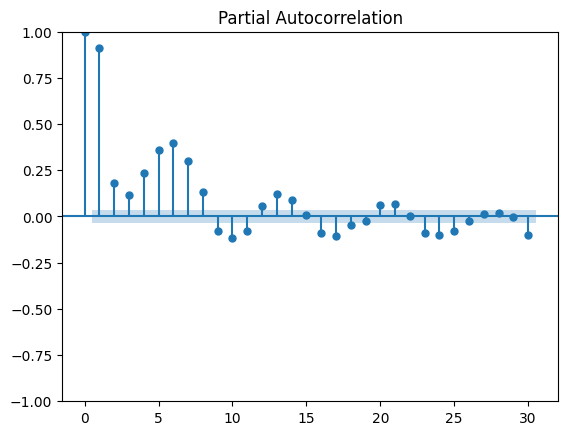

                                      SARIMAX Results                                      
Dep. Variable:                         number_sold   No. Observations:                 3287
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 8)   Log Likelihood              -20084.380
Date:                             Fri, 20 Dec 2024   AIC                          40182.760
Time:                                     13:41:53   BIC                          40225.425
Sample:                                 01-01-2010   HQIC                         40198.038
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7246      0.021    -35.038      0.000      -0.765      -0.684
ar.L2          0.2730      

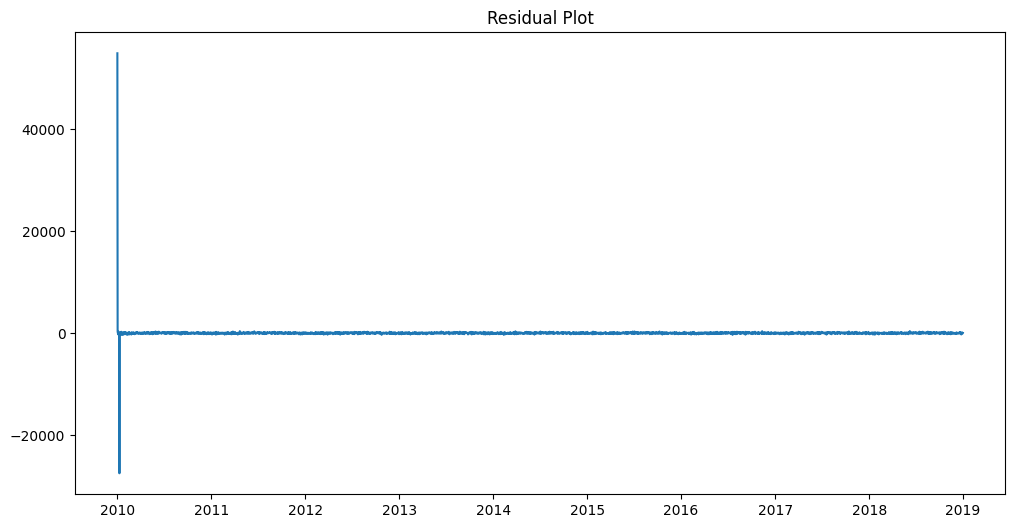

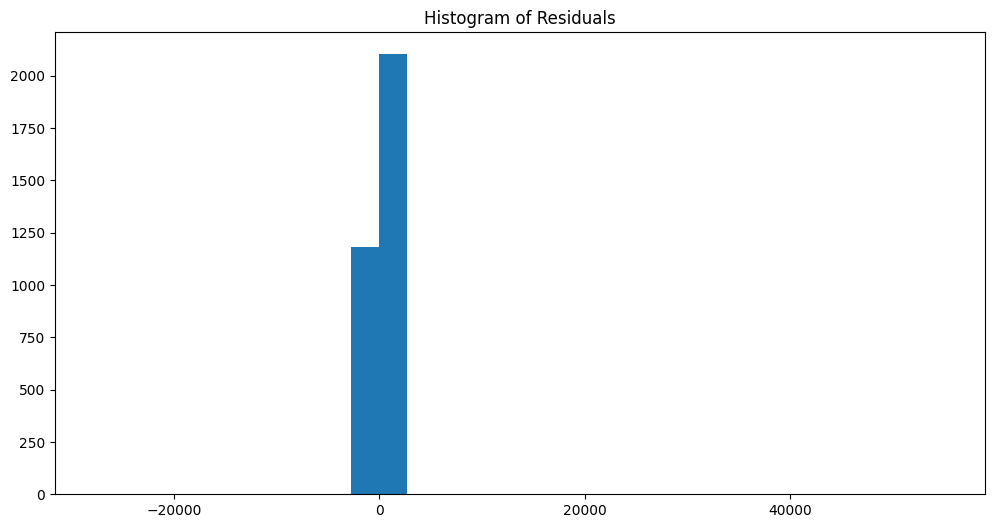

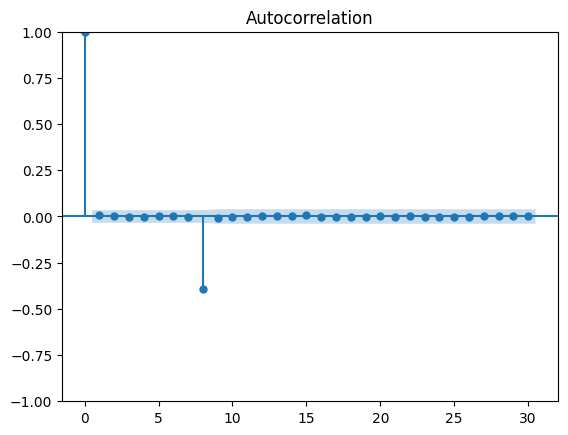

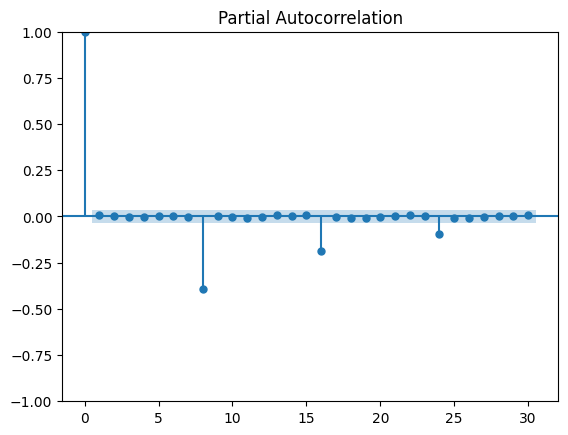

MAPE: 0.00
RMSE: 309.58
R-squared: -0.03


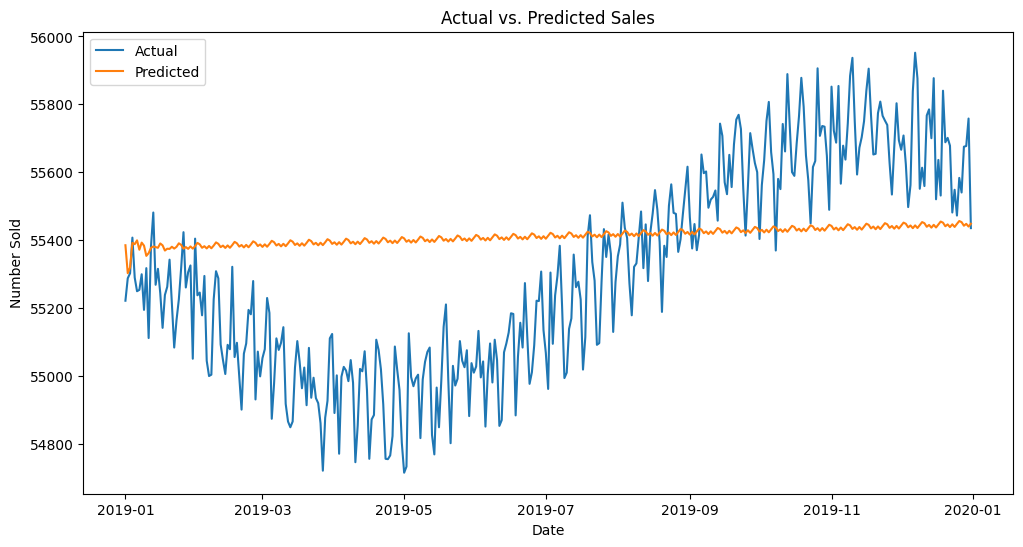

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Агрегирование данных по продажам
train_data = train_data.groupby('Date')['number_sold'].sum().reset_index()
test_data = test_data.groupby('Date')['number_sold'].sum().reset_index()
train_data = train_data.set_index('Date')
test_data = test_data.set_index('Date')

# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(train_data['number_sold'], label='Train')
plt.plot(test_data['number_sold'], label='Test')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Time Series of Total Sales')
plt.legend()
plt.show()

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lag Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


test_stationarity(train_data['number_sold'])

# Дифференцирование для достижения стационарности
diff_order = 0
data_diff = train_data['number_sold'].copy()
while True:
    result = adfuller(data_diff.diff().dropna())
    if result[1] < 0.05:
        diff_order += 1
        break
    diff_order += 1
    data_diff = data_diff.diff().dropna()

print(f'Order of differencing: {diff_order}')

# Анализ ACF и PACF для выбора порядка модели
plot_acf(data_diff, lags=30)
plt.show()
plot_pacf(data_diff, lags=30)
plt.show()

model = SARIMAX(train_data['number_sold'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 8))
model_fit = model.fit()
print(model_fit.summary())

predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Анализ остатков
residuals = model_fit.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residual Plot')
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.show()

# Проверка на автокорреляцию остатков
plot_acf(residuals, lags=30)
plt.show()
plot_pacf(residuals, lags=30)
plt.show()

# Метрики качества
mape = mean_absolute_percentage_error(test_data['number_sold'], predictions)
rmse = np.sqrt(mean_squared_error(test_data['number_sold'], predictions))
r2 = r2_score(test_data['number_sold'], predictions)

print(f'MAPE: {mape:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(test_data['number_sold'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.show()